**Check tensorflow environment**

In [ ]:
import tensorflow as tf
print(tf.__version__)

from tensorflow.python.client import device_lib
device_lib.list_local_devices() #list available compute devices

# !cat /proc/cpuinfo #view runtime CPU
# !cat /proc/meminfo #view runtime memory

2.7.0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2593927266448061960
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11321147392
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15880307085694175262
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

**Setup storage environment**
1. Mount google drive
2. Define PROJECT_PATH & set as working dir

In [ ]:
#mount google drive
from google.colab import drive

ROOT = "/content/drive"

drive.mount(ROOT) #mount google drive at /content/drive in session

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#define project
import os
PROJ = "MyDrive/github/mnist"
PROJECT_PATH = os.path.join(ROOT, PROJ)
# !mkdir "{PROJECT_PATH}"

os.chdir(PROJECT_PATH) #change working dir to PROJECT_PATH
!ls #check that we're in the project directory

logs  models  __pycache__  train_cnn.ipynb  utils


Load data splits

In [ ]:
import utils.cnn_utils as utils
train, valid, test = utils.get_data_splits()

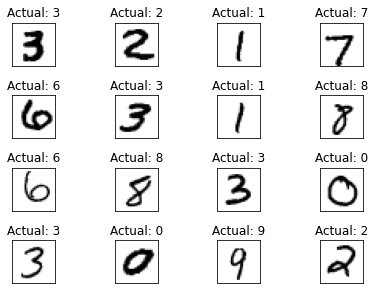

In [ ]:
#visualize data from training set
nrows = 4
ncols=4 #grid size for plot of randomly selected training samples

sample_indices = np.random.randint(low=0, high=train[0].shape[0], size=nrows*ncols)
utils.plot_result(train[0][sample_indices], train[1][sample_indices],
                  nrows=nrows, ncols=ncols)

Find optimal learning rate for model

1688/1688 [==============================] - 55s 26ms/step - loss: 1.6516 - accuracy: 0.3911 - val_loss: 2.3840 - val_accuracy: 0.0987


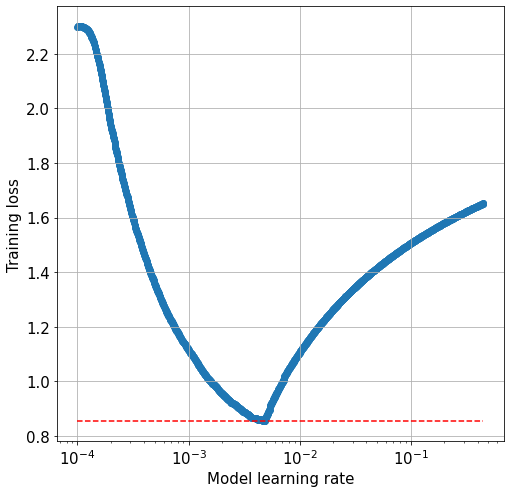

In [ ]:
utils.clear_backend()

#define callbacks
lrsweep_cb = utils.sweep_learning_rate(factor=1.005)

model = utils.build_model_cnn(lr=1e-4)
model.fit(train[0], train[1], epochs=1,
              validation_data=[valid[0], valid[1]],
              batch_size=32, callbacks = [lrsweep_cb,])
lrsweep_cb.plot_lr_sweep()

In [ ]:
from tensorflow import keras

#cnn_mode_1 with lr=1e-3 (<half of maximum/infection point)
utils.clear_backend()

#define paths
modelpath = './models/cnn_model_1.h5'
logdir = './logs/cnn_model_1'

#callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath=modelpath,
    save_best_only=True,
    )
tensorboard_cb = keras.callbacks.TensorBoard(logdir)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10)

model = utils.build_model_cnn(lr=1e-3)
model.fit(train[0], train[1], epochs=100, 
          validation_data=[valid[0], valid[1]], 
          batch_size=32, 
          callbacks = [checkpoint_cb, earlystopping_cb, tensorboard_cb])

Epoch 1/100
1688/1688 [==============================] - 38s 22ms/step - loss: 0.3066 - accuracy: 0.9086 - val_loss: 0.0821 - val_accuracy: 0.9807
Epoch 2/100
1688/1688 [==============================] - 37s 22ms/step - loss: 0.0985 - accuracy: 0.9772 - val_loss: 0.0663 - val_accuracy: 0.9855
Epoch 3/100
1688/1688 [==============================] - 36s 21ms/step - loss: 0.0724 - accuracy: 0.9832 - val_loss: 0.0697 - val_accuracy: 0.9848
Epoch 4/100
1688/1688 [==============================] - 36s 21ms/step - loss: 0.0655 - accuracy: 0.9863 - val_loss: 0.0690 - val_accuracy: 0.9853
Epoch 5/100
1688/1688 [==============================] - 36s 21ms/step - loss: 0.0579 - accuracy: 0.9873 - val_loss: 0.0599 - val_accuracy: 0.9882
Epoch 6/100
1688/1688 [==============================] - 36s 21ms/step - loss: 0.0464 - accuracy: 0.9892 - val_loss: 0.0429 - val_accuracy: 0.9912
Epoch 7/100
1688/1688 [==============================] - 36s 21ms/step - loss: 0.0460 - accuracy: 0.9896 - val_loss: 0

In [ ]:
#view learning curves in tensorboard
%reload_ext tensorboard
%tensorboard --logdir './logs/'

Error analysis

In [ ]:
from tensorflow import keras
import numpy as np

#define paths
modelpath = './models/cnn_model_1.h5'
m = keras.models.load_model(modelpath) #load model
y_proba = m.predict(test[0])
y_pred = np.argmax(y_proba, axis=-1) #get predictions

In [ ]:
indices = np.where(y_pred-test[1]!=0)
indices[0].shape

(69,)

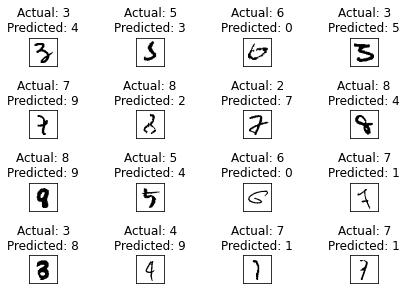

In [ ]:
use_idx = indices[:16]
nrows=4
ncols = 4
utils.plot_result(test[0][use_idx], test[1][use_idx],
                  y_pred[use_idx],
                  nrows=nrows, ncols=ncols)

